In [108]:
import cv2
import glob
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## To Done
- Camera calibration
- Distortion correction
- Color/gradient threshold
- Perspective transform

#### Then,
- Detect lane lines
- Determine the lane curvature

### 1. Camera Calibration
- Compute camera calibration matrix and distortion
coefficients
- Try out various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible
- Identify four source points for perspective transform

Camera Calibration
The calibration images in the lesson exercise were taken with a different camera setting and a different chessboard pattern than the calibration images for the project. You need to set your chessboard size to 9x6 for the project instead of 8x6 as in the lesson.

This image is: <class 'numpy.ndarray'> with dimensions: (360, 540, 3)


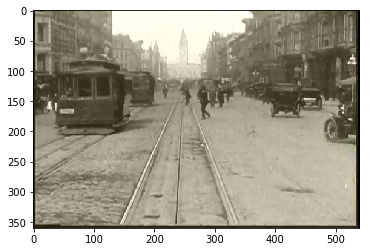

In [288]:
image = mpimg.imread('frames/frame10019.jpg')

print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image);

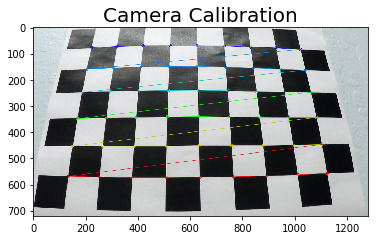

In [289]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners. Show first img.
counter = 0
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        
        objpoints.append(objp)
        imgpoints.append(corners)
        if counter == 2:
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            fig, ax = plt.subplots()
            ax.set_title('Camera Calibration', fontsize=20)
            ax.imshow(img)
            plt.show('img', img)
        counter += 1

cv2.destroyAllWindows()

plt.show()

### Undistort using camera calibration

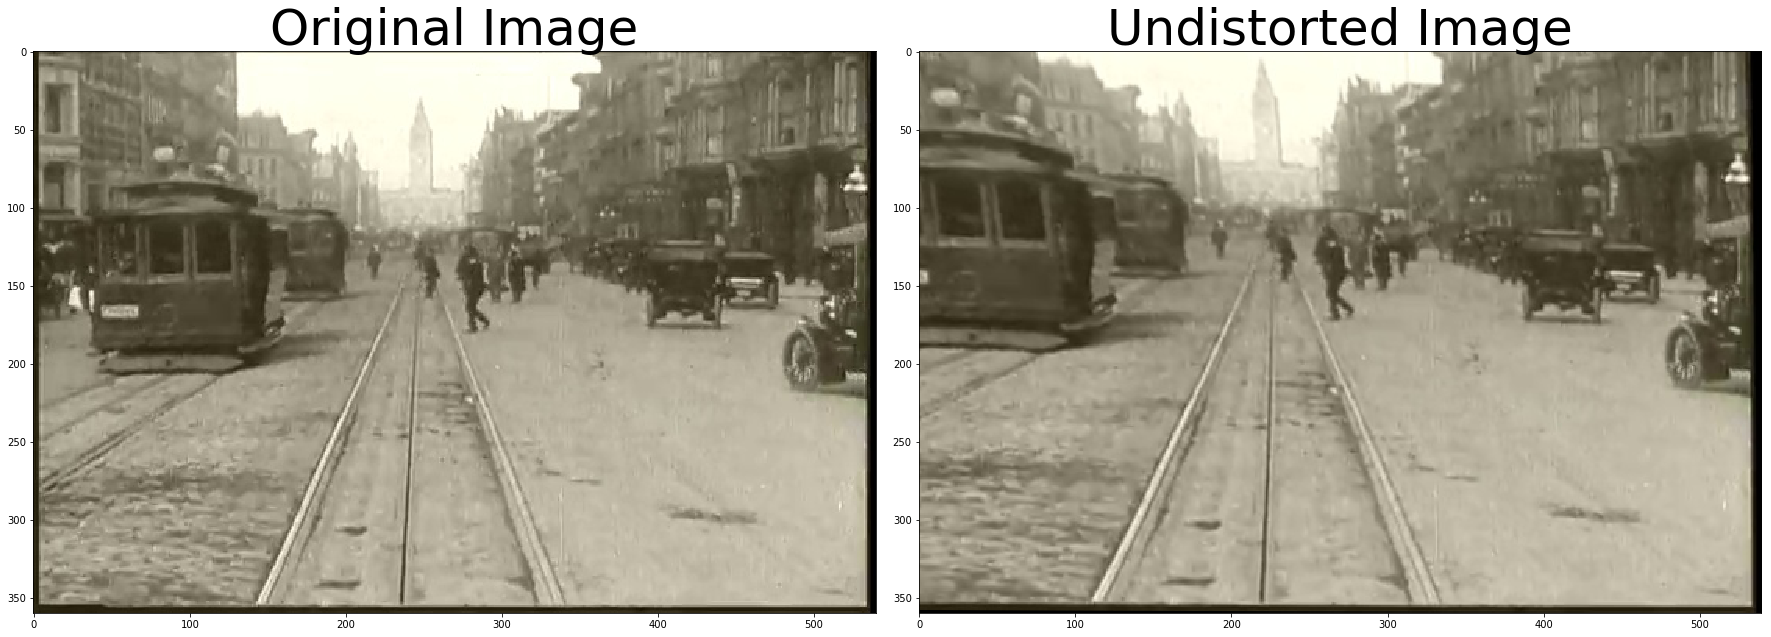

In [290]:
def camera_cal(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() to generate camera matrix
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

# undistort an image
img = cv2.imread(images[6])
mtx, dist = camera_cal(image, objpoints, imgpoints)
undistorted = cv2.undistort(image, mtx, dist, None, mtx)

# Visualize an undistorted calibration image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

### Binary image with more visible lane lines

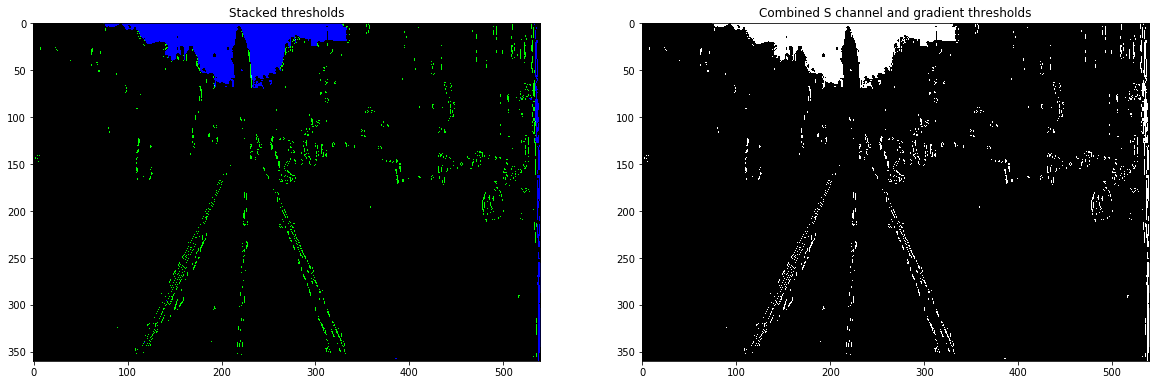

In [291]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
def process_to_binary(undistorted, thresh_min = 60, thresh_max = 80, s_thresh_min = 190, s_thresh_max = 255):
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Sobel x
    # Grayscale image, only for sobel b/c standard grayscaling loses color information for the lane lines
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

color_binary, combined_binary = process_to_binary(undistorted)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray');

### Perspective Tranformation, or Getting a 'Bird's-Eye View'

In [292]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # 4) If corners found: 
    if ret == True:
    # Draw and display the corners
            # a) draw corners
            cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
            src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
                 # Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 # One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 # We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            img_size = (gray.shape[1], gray.shape[0])
            offset = 100
            dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            M = cv2.getPerspectiveTransform(src, dst)
            # e) use cv2.warpPerspective() to warp your image to a top-down view
            warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

            return warped, M
    return img, None

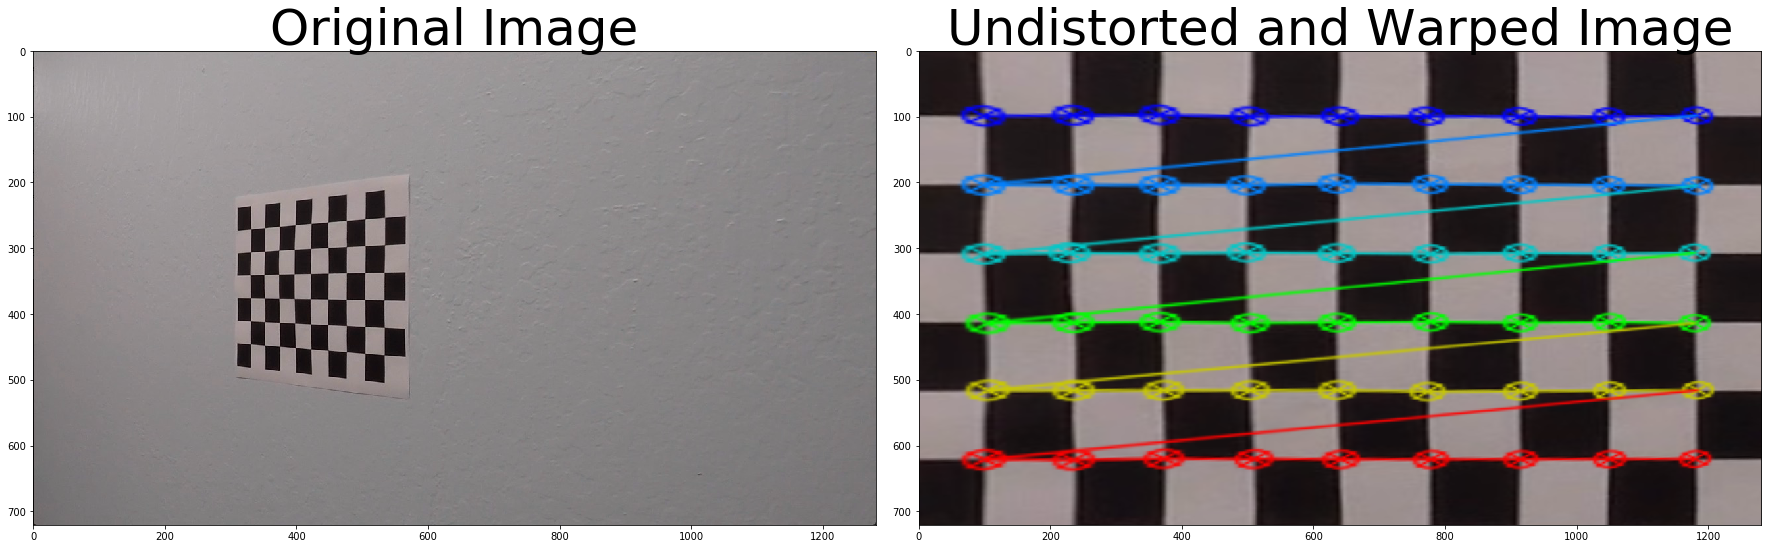

In [293]:
# number of interior chessboard corners
nx = 9
ny = 6
img = cv2.imread(images[3])
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

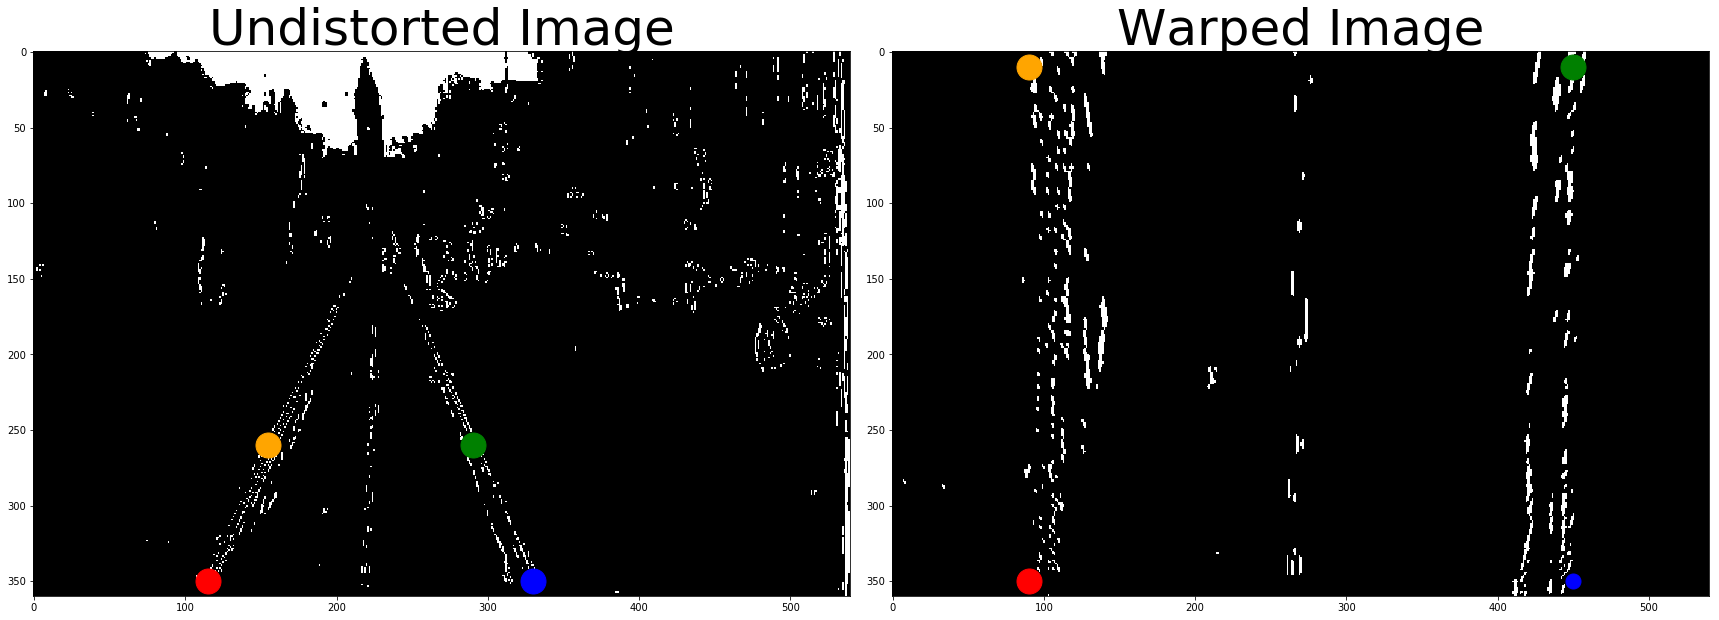

In [294]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Undistorted Image', fontsize=50)
ax1.plot(290, 260, '.', markersize=50, color = 'green')  # top-right
ax1.plot(330, 350, '.', markersize=50, color = 'blue')  # bottom-right
ax1.plot(115, 350, '.', markersize=50, color = 'red') # bottom-left
ax1.plot(155, 260, '.', markersize=50, color = 'orange')  # top-left

def warp(image, inp_mtx, offset = 100):
    # offset is for drawing dst points
    # Grab the image shape
    img_size = (image.shape[1], image.shape[0])
        
    # Source points
    src = np.float32(inp_mtx)

    # Result points, chosen to be an arbitrary rectangle        
    dst = np.float32([[img_size[0] - offset, 0], 
                    [img_size[0] - offset, img_size[1]], 
                    [offset, img_size[1]], 
                    [offset, 0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Return the resulting image and matrix
    return warped, M
    
inp_mtx = [[[ 290, 260]], 
           [[ 330, 350]], 
           [[ 115, 350]],
           [[ 155, 260]]]
warped, perspective_mtx = warp(undistorted, inp_mtx)
binary_warped, perspective_mtx = warp(combined_binary, inp_mtx)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
img_size = (binary_warped.shape[1], binary_warped.shape[0])

# offset is calculated so that width = height, creating a square
offset = (img_size[0]-img_size[1])/2

ax2.plot(img_size[0] - offset, 10, '.', markersize=50, color = 'green')  # top-right
ax2.plot(img_size[0] - offset, img_size[1] - 10, '.', markersize=30, color = 'blue') # bottom-right
ax2.plot(offset, img_size[1] - 10, '.', markersize=50, color = 'red')  # bottom-left
ax2.plot(offset, 10, '.', markersize=50, color = 'orange');  # top-left

### Calculating the distance between tracks on Market St.

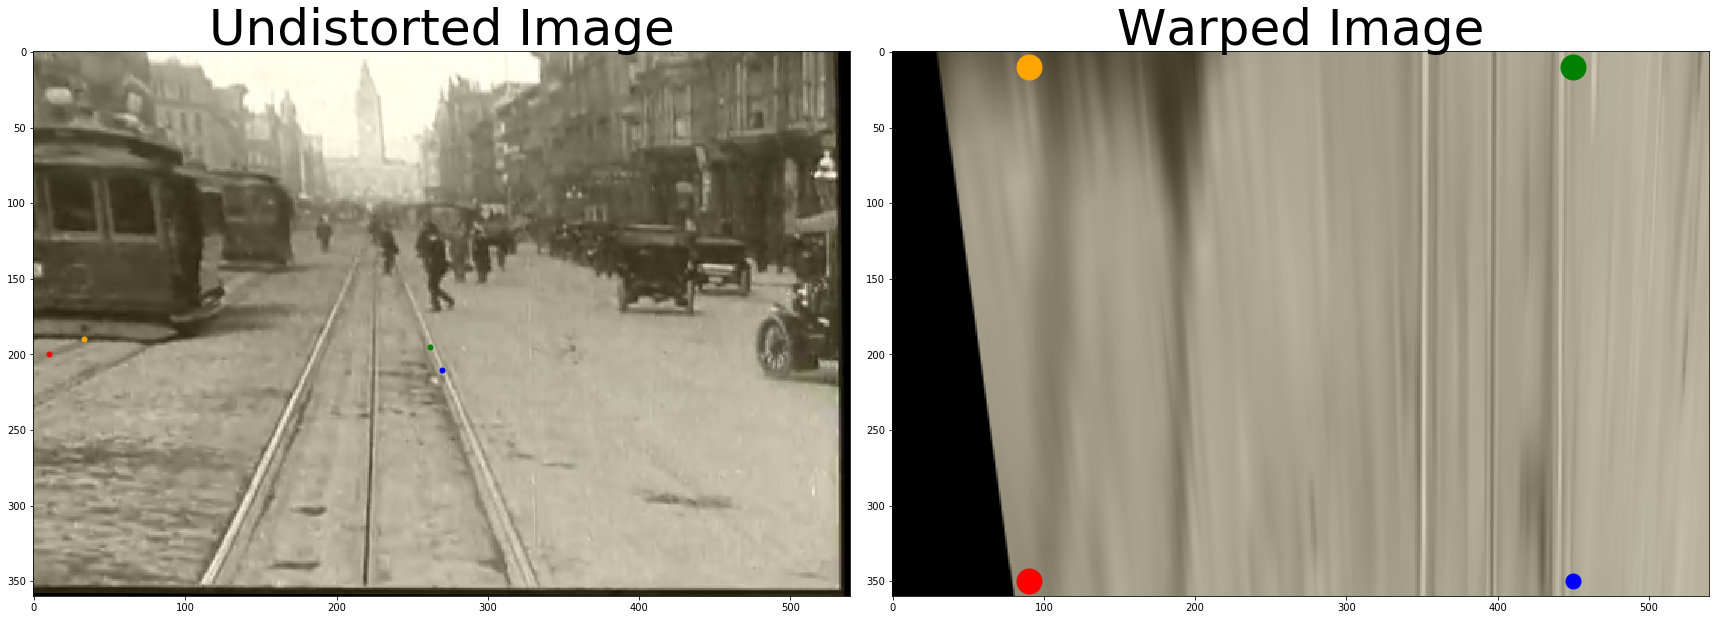

In [309]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted, cmap='gray')
ax1.set_title('Undistorted Image', fontsize=50)
ax1.plot(262, 195, '.', markersize=10, color = 'green')  # top-right
ax1.plot(270, 210, '.', markersize=10, color = 'blue')  # bottom-right
ax1.plot(10, 200, '.', markersize=10, color = 'red') # bottom-left
ax1.plot(33, 190, '.', markersize=10, color = 'orange')  # top-left

inp_mtx = [[[ 262, 195]], 
           [[ 270, 210]], 
           [[ 10, 200]],
           [[ 33, 190]]]
warped, perspective_mtx = warp(undistorted, inp_mtx)
binary_warped_tracks, perspective_mtx = warp(combined_binary, inp_mtx)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
img_size = (binary_warped_tracks.shape[1], binary_warped_tracks.shape[0])

# offset is calculated so that width = height, creating a square
offset = (img_size[0]-img_size[1])/2

ax2.plot(img_size[0] - offset, 10, '.', markersize=50, color = 'green')  # top-right
ax2.plot(img_size[0] - offset, img_size[1] - 10, '.', markersize=30, color = 'blue') # bottom-right
ax2.plot(offset, img_size[1] - 10, '.', markersize=50, color = 'red')  # bottom-left
ax2.plot(offset, 10, '.', markersize=50, color = 'orange');  # top-left

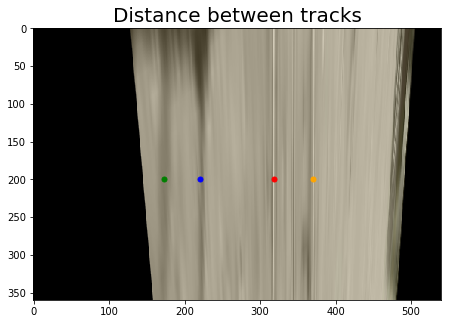

Distance between tracks: 8.42 feet


In [307]:
# TESTING
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Distance between tracks', fontsize=20)
ax.imshow(warped)
tr_ll, tr_lr, tr_rl, tr_rr = 173, 220, 318, 370
ax.plot(tr_ll, 200, '.', markersize=10, color = 'green')  # top-right
ax.plot(tr_lr, 200, '.', markersize=10, color = 'blue')  # bottom-right
ax.plot(tr_rl, 200, '.', markersize=10, color = 'red') # bottom-left
ax.plot(tr_rr, 200, '.', markersize=10, color = 'orange')  # top-left
plt.show('img', warped)

# Real-world track width is 4'8.5"
track_width_rw = 4 + 8.5/12
track_width_px = tr_rr - tr_rl
dist_btwn_tracks_px = tr_rr - tr_ll - 2*track_width_px

# track_width_px/track_width_rw = dist_btwn_tracks_px/dist_btwn_tracks_rw
dist_btwn_tracks_rw = dist_btwn_tracks_px*track_width_rw/track_width_px
print("Distance between tracks:", round(dist_btwn_tracks_rw, 2), "feet")

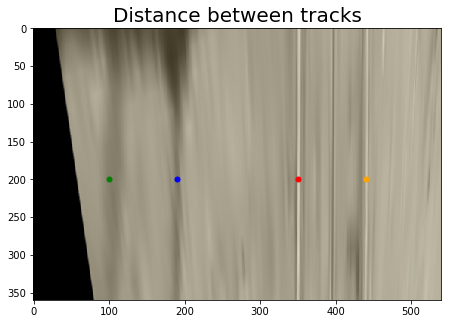

Distance between tracks: 8.37 feet


In [313]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('Distance between tracks', fontsize=20)
ax.imshow(warped)
tr_ll, tr_lr, tr_rl, tr_rr = 100, 190, 350, 440
ax.plot(tr_ll, 200, '.', markersize=10, color = 'green')  # top-right
ax.plot(tr_lr, 200, '.', markersize=10, color = 'blue')  # bottom-right
ax.plot(tr_rl, 200, '.', markersize=10, color = 'red') # bottom-left
ax.plot(tr_rr, 200, '.', markersize=10, color = 'orange')  # top-left
plt.show('img', warped)

# Real-world track width is 4'8.5"
track_width_rw = 4 + 8.5/12
track_width_px = tr_rr - tr_rl
dist_btwn_tracks_px = tr_rr - tr_ll - 2*track_width_px

# track_width_px/track_width_rw = dist_btwn_tracks_px/dist_btwn_tracks_rw
dist_btwn_tracks_rw = dist_btwn_tracks_px*track_width_rw/track_width_px
print("Distance between tracks:", round(dist_btwn_tracks_rw, 2), "feet")

### Can calculate distance to vanishing point with tangent. Similar triangles: pixels to feet

### 2. Finding the Lane Lines
- Peaks in a histogram
- Use two highest peaks from histogram, then use sliding windows to find lane lines
- Since the lanes do not move much, search in a margin around the prior lane lines

#### Histogram Peaks to Identify Lane Lines

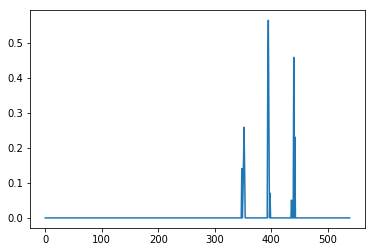

In [260]:
# warped's range is 0-255, so normalize back to 0-1
img = binary_warped/255

def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram);

#### Sliding Window

In [174]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [175]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

#### Find Lane Lines

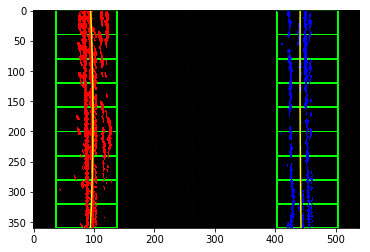

In [176]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Number of sliding windows
    nwindows = 9
    # The width of the windows +/- margin
    margin = 50
    # Minimum number of pixels found to recenter window
    minpix = 1500

    # Height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit


out_img, left_fit, right_fit = fit_polynomial(binary_warped)

plt.imshow(out_img);

#### Search from Prior

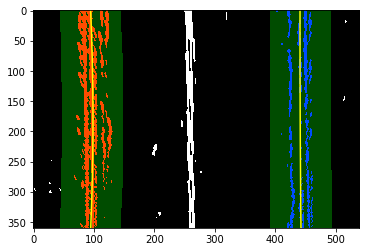

In [177]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result);

#### Use a convolution to find lane line

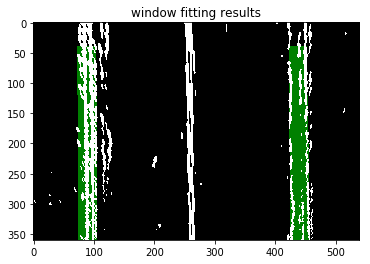

In [178]:
# window settings
window_width = 31 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 1 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(binary_warped)
    r_points = np.zeros_like(binary_warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, .5, 0.0) # overlay the orignal road image with window results
    
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((binary_warped, binary_warped, binary_warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


### 3. Determine Lane Curvature
- Use second order polynomial to fit line
- scale using meters/pixel
- Since the lanes do not move much, search in a margin around the prior lane lines

In [179]:
# get left and right centroids for polynomial fitting
left_centroids = np.array([x[0] for x in window_centroids][::-1])
right_centroids = np.array([x[1] for x in window_centroids][::-1])
ploty = np.linspace(0, image.shape[0]-1, num=4)

def measure_curvature_pixels(ploty, left_centroids, right_centroids):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # set points to cover same y-range as image
    left_fit = np.polyfit(ploty, left_centroids, 2)
    right_fit = np.polyfit(ploty, right_centroids, 2)
    left_fit_line = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit_line = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x, y in non-pixel space (meters)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_centroids*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_centroids*xm_per_pix, 2)
    
    # Calculation of radius of curvature for each line in pixels
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Calculation of radius of curvature for each line in meters
    left_curverad_m = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_m = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad_m, right_curverad_m, left_fit_line, right_fit_line


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad, left_fit, right_fit = measure_curvature_pixels(ploty, left_centroids, right_centroids)

print("Radius of left curve (m):", round(left_curverad, 2), "and right:", round(right_curverad, 2))

Radius of left curve (m): 2.604556559575479e+17 and right: 1.8541332975853804e+16


Once the parabola coefficients are obtained, in pixels, convert them into meters. For example, if the parabola is x= a*(y**2) +b*y+c; and mx and my are the scale for the x and y axis, respectively (in meters/pixel); then the scaled parabola is x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c

the lane is about 30 meters long and 3.7 meters wide.

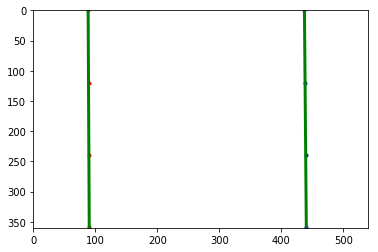

In [180]:
# Plot up the data
mark_size = 3
plt.plot(left_centroids, ploty, 'o', color='red', markersize=mark_size)
plt.plot(right_centroids, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, image.shape[1])
plt.ylim(0, image.shape[0])
plt.plot(left_fit, ploty, color='green', linewidth=3)
plt.plot(right_fit, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

### Ok, now it is fitted. Let's print out a 4'8.5" x 4'8.5" square!

In [166]:
mean_warped_px_dist = (right_fit-left_fit).mean()
print(mean_warped_px_dist)

348.99999999999966


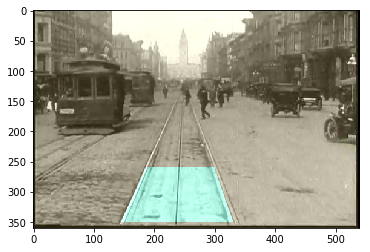

In [165]:
def unwarp(image, warped_img, persp_M, left_fit_line, right_fit_line):
    Minv = np.linalg.inv(persp_M)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_line, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_line, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, new_warp, 0.3, 0)
    return result

plt.imshow(unwarp(undistorted_cars, binary_warped, perspective_mtx, left_fit, right_fit));